# Data Science Job Posting Analysis Assignment

In this assignment we will work with a dataset that incudes information about Data Science scraped from Glassdoor. You will notice that in some cases the prompt in the assignment is a bit vague, and thats okay.

For each prompt write how you tackled the question / data cleaning task and any assumptions you made. Some questions can be interpreted differently and data cleaning can lead to different outcomes, so its perfectly okay for this assignment to have results different from your peers. Thats why its important to note your approach.

This assignment is meant to get you familar with Python, Pandas and visualization libraries (like matplotlib).



## Step 1: Load the Dataset

This solution uses a synthetic dataset generated in the notebook to demonstrate the analyses. In practice, replace the generation step with `pd.read_csv()` or appropriate loader.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Load the CSV file (check filename from the print above)
# Use on_bad_lines='skip' to handle potential parsing errors
df = pd.read_csv("/content/DataScientist.csv", on_bad_lines='skip')

# Display the first rows of the dataset
print('Dataset overview:')
display(df.head())

Dataset overview:


,Unnamed: 0,index,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,Hopper\n3.5,"New York, NY","Montreal, Canada",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,Unknown / Non-Applicable,-1,-1
1,1,1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),"At Noom, we use scientifically proven methods ...",4.5,Noom US\n4.5,"New York, NY","New York, NY",1001 to 5000 employees,2008,Company - Private,"Health, Beauty, & Fitness",Consumer Services,Unknown / Non-Applicable,-1,-1
2,2,2,Data Science Manager,$111K-$181K (Glassdoor est.),Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,-1.0,Decode_M,"New York, NY","New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable,-1,True
3,3,3,Data Analyst,$111K-$181K (Glassdoor est.),Sapphire Digital seeks a dynamic and driven mi...,3.4,Sapphire Digital\n3.4,"Lyndhurst, NJ","Lyndhurst, NJ",201 to 500 employees,2019,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,"Zocdoc, Healthgrades",-1
4,4,4,"Director, Data Science",$111K-$181K (Glassdoor est.),"Director, Data Science - (200537)\nDescription...",3.4,United Entertainment Group\n3.4,"New York, NY","New York, NY",51 to 200 employees,2007,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"BBDO, Grey Group, Droga5",-1


## Step 2: Data Cleaning

You will notice that data cleaning is required for this dataset due to inconsistences.


- Standardize column names (ex. lower case all column names)

- Parse `Salary Estimate` to extract numeric salary values (handle ranges, for example compute the average salary based on the low and high range provided)

- Deduplicate rows if necessary (duplicates are defined as repeated columns in each column)

- Determine columns with too many missing values. Note, some datasets have Nulls for missing values while others might use other characters or notations.

- Standarize job titles. For example, Sr. Data Scientist is equivalent to Senior Data Scientist but we cannot directly compare these two roles without some data cleaning on our part.



In [2]:
# 1 Standardize column names
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ', '_')
df.head()
print(df.columns)

# 3 Deduplicate rows
df.drop_duplicates(inplace=True)

# Filter out invalid rows based on salary estimate
df = df[df['salary_estimate'].notna() & (df['salary_estimate'] != '-1')].copy()

# Determine if the salary is hourly
df['is_hourly'] = df['salary_estimate'].str.lower().str.contains(r'per hour|/hr|hourly')

# Separate annual and hourly salaries
df_annual = df[~df['is_hourly']].copy()
df_hourly = df[df['is_hourly']].copy()

# Annual Salary Cleaning
df_annual['salary_cleaned'] = (
    df_annual['salary_estimate']
    .str.replace(r'\(.*?\)', '', regex=True)                # Remove content within parentheses
    .str.replace(r'(?i)employer provided salary:', '', regex=True) # Remove employer provider tag
    .str.replace(r'(?i)glassdoor est.', '', regex=True)       # Remove Glassdoor estimate tag
    .str.replace('–', '-', regex=False)                    # Replace long dash (en dash)
    .str.replace('—', '-', regex=False)                    # Replace long dash (em dash)
    .str.replace('$', '', regex=False)                      # Remove dollar sign
    .str.replace('K', '', regex=False)                      # Remove 'K' for thousands
    .str.strip()                                           # Remove surrounding whitespace
)

# Split into low and high limits
salary_split_annual = df_annual['salary_cleaned'].str.split('-', expand=True)
# Convert to numeric and scale by 1000 (K)
df_annual['low_salary'] = pd.to_numeric(salary_split_annual[0].str.strip(), errors='coerce') * 1000
df_annual['high_salary'] = pd.to_numeric(salary_split_annual[1].str.strip(), errors='coerce') * 1000

# Hourly Salary Cleaning
df_hourly['salary_cleaned'] = (
    df_hourly['salary_estimate']
    .str.replace(r'\(.*?\)', '', regex=True)              # Remove content within parentheses
    .str.replace(r'(?i)per hour|/hr|hourly', '', regex=True) # Remove hourly indicators
    .str.replace('$', '', regex=False)                    # Remove dollar sign
    .str.strip()
)

# Split into low and high limits
salary_split_hourly = df_hourly['salary_cleaned'].str.split('-', expand=True)
HOURS_PER_YEAR = 40 * 52
# Convert to numeric and scale by annual hours
df_hourly['low_salary'] = pd.to_numeric(salary_split_hourly[0].str.strip(), errors='coerce') * HOURS_PER_YEAR
df_hourly['high_salary'] = pd.to_numeric(salary_split_hourly[1].str.strip(), errors='coerce') * HOURS_PER_YEAR

# Concatenate Annual + Hourly
df = pd.concat([df_annual, df_hourly], ignore_index=True)

# Calculate the average salary (used for statistical central tendency)
df['average_salary'] = (df['low_salary'] + df['high_salary']) / 2

# Remove temporary columns only
df.drop(['salary_estimate', 'salary_cleaned'], axis=1, inplace=True)

# Output results
print(df[['is_hourly', 'low_salary', 'high_salary', 'average_salary']])

Index(['unnamed:_0', 'index', 'job_title', 'salary_estimate',
       'job_description', 'rating', 'company_name', 'location', 'headquarters',
       'size', 'founded', 'type_of_ownership', 'industry', 'sector', 'revenue',
       'competitors', 'easy_apply'],
      dtype='object')
      is_hourly  low_salary  high_salary  average_salary
0         False      111000       181000        146000.0
1         False      111000       181000        146000.0
2         False      111000       181000        146000.0
3         False      111000       181000        146000.0
4         False      111000       181000        146000.0
...         ...         ...          ...             ...
3904       True       35360        56160         45760.0
3905       True       35360        56160         45760.0
3906       True       35360        56160         45760.0
3907       True       35360        56160         45760.0
3908       True       35360        56160         45760.0

[3909 rows x 4 columns]


In [3]:
# Determine columns with too many missing values
# Unified missing value symbols
missing_value_placeholders = ['-1', 'Unknown', 'Unknown / Non-Applicable', 'N/A', 'None']
df.replace(missing_value_placeholders, pd.NA, inplace=True)

# Calculate missing percentage
# Find and delete too many missing values columns
missing_percentage = (df.isnull().sum() / len(df)) * 100

print("\n--- Each Columns Missing Percentage---")
print(missing_percentage.sort_values(ascending=False).to_markdown())

# 4. set a threshold for too many missing value
threshold = 70
columns_to_drop = missing_percentage[missing_percentage > threshold].index.tolist()

if columns_to_drop:
    print(f"Deleting missing value percentage more than {threshold}% 's column: {columns_to_drop}")
    # Delete missing value columns
    df.drop(columns=columns_to_drop, inplace=True)
    print(f"Delete successful, DataFrame has {len(df.columns)} columns left")
else:
    print(f"No column missing percentage more than {threshold}%, No need to delete")



--- Each Columns Missing Percentage---
|                   |        0 |
|:------------------|---------:|
| easy_apply        | 95.8046  |
| competitors       | 70.6063  |
| revenue           | 35.6101  |
| industry          | 13.9678  |
| sector            | 13.9678  |
| size              |  7.82809 |
| type_of_ownership |  6.83039 |
| headquarters      |  6.13968 |
| job_description   |  0       |
| job_title         |  0       |
| index             |  0       |
| unnamed:_0        |  0       |
| founded           |  0       |
| rating            |  0       |
| company_name      |  0       |
| location          |  0       |
| is_hourly         |  0       |
| low_salary        |  0       |
| high_salary       |  0       |
| average_salary    |  0       |
Deleting missing value percentage more than 70% 's column: ['competitors', 'easy_apply']
Delete successful, DataFrame has 18 columns left


In [15]:
def standardize_job_titles(series: pd.Series) -> pd.Series:
    s = series.astype(str)
    # cleaning: replace symbols to space
    s = s.str.replace(r"[_/|&]", " ", regex=True)
    s = s.str.replace(r"[-–—]", " ", regex=True)
    s = s.str.replace(r"[.,;:!?\t]+", " ", regex=True)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip().str.lower()

    # replace abbreviation to full
    s = s.str.replace(r"\bml\b", "machine learning", regex=True)
    s = s.str.replace(r"\bmle\b", "machine learning engineer", regex=True)
    s = s.str.replace(r"\bai\b", "artificial intelligence", regex=True)
    s = s.str.replace(r"\bbi\b", "business intelligence", regex=True)
    s = s.str.replace(r"\bnlp\b", "natural language processing", regex=True)
    s = s.str.replace(r"\bcv\b", "computer vision", regex=True)
    s = s.str.replace(r"\bllm\b", "large language model", regex=True)
    s = s.str.replace(r"\bgenai\b", "generative ai", regex=True)

    # replace srsr. jr. jr to senior junior
    s = s.str.replace(r"\bsr\.\b", "senior", regex=True)
    s = s.str.replace(r"\bsr\b", "senior", regex=True)
    s = s.str.replace(r"\bjr\.\b", "junior", regex=True)
    s = s.str.replace(r"\bjr\b", "junior", regex=True)


    s = s.str.replace(r"\s+", " ", regex=True).str.strip()

    # Abbreviation to all captial
    def smart_title(x: str) -> str:
        t = x.title()
        convert_up = ["Ai", "Ml", "Bi", "Nlp", "Cv", "Llm"]

        for acronym in convert_up:
            t = t.replace(acronym, acronym.upper())
        return t
    return s.apply(smart_title)

# create and print standardized job title
df["job_title_std"] = standardize_job_titles(df["job_title"])
print(df["job_title_std"])
print("\nTop standardized titles:\n", df["job_title_std"].value_counts())

0                                   Senior Data Scientist
1                        Data Scientist Product Analytics
2                                    Data Science Manager
4                                   Director Data Science
5                                          Data Scientist
                              ...                        
3904    Associate Scientist Process Development Manufa...
3905    Configuration Data Analyst San Antonio Tx Us I...
3906                               Research Scientist Iii
3907                                 Senior Data Engineer
3908      Lead Of Cybersecurity Data Protection Analytics
Name: job_title_std, Length: 3687, dtype: object

Top standardized titles:
 job_title_std
Data Engineer                                                                                          258
Data Scientist                                                                                         250
Data Analyst                                              

### Standardize column names (ex. lower case all column names)
I converted all column names to lowercase and replaced all spaces with underscores.
### Parse Salary Estimate to extract numeric salary values (handle ranges, for example compute the average salary based on the low and high range provided)
Convert text to numeric values.
I removed all salary estimates as ′−1′ rows, because these are missing values ​​that cannot be parsed.


I use the keyword 'per hour' to intelligently split the data into annual salary group and hourly salary group.


I used str.replace() and regular expressions for two sets of data to remove all non-numeric characters, e.g. ′K′ , ′$′ and text in brackets (such as (Glassdoor est.)).


I passed ′−′ The symbol divides out the upper and lower limits of the salary range and multiplies by 1,000 to get low and high salaries in US dollars.


I also extract the range, but must be multiplied by the preset annual working hours (40×52) to convert hourly salary into annual salary uniformly.


Finally, I calculated the average salary, which is the core metric we need to final analysis.
### Deduplicate rows if necessary (duplicates are defined as repeated columns in each column)
I used the df.drop_duplicates(inplace=True) command to remove all the exact same duplicate lines directly.
### Determine columns with too many missing values. Note, some datasets have Nulls for missing values while others might use other characters or notations.
Missing values ​​uniform: I first defined a containing all non-standard missing values ​​such as ′−1′ , Unknown, N/A list and replace them with standard pd.NA.

This is the core step to ensure that all missing values ​​are recognized by the isnull() function.  

Calculate the Missing Rate: I calculated the percentage of missing values ​​per column as a total number of rows.  

Threshold Deletion: I set a very high threshold. Any column with a missing rate exceeding this threshold will be deleted.
### Standarize job titles. For example, Sr. Data Scientist is equivalent to Senior Data Scientist but we cannot directly compare these two roles without some data cleaning on our part.
I first remove all unnecessary symbols, numbers and extra spaces with regular expressions (, +, #).

I use str.replace() to accurately replace all position level abbreviations such as sr. → senior and function abbreviations such as ml → machine learning with the full name.  

## Step 3: Exploratory Data Analysis (EDA)

### 3.1 Basic Overview
What are the top or most popularjob titles?
What are the top companies (based on job posting)?
What are the top 5 industry sectors (based on job postings)?

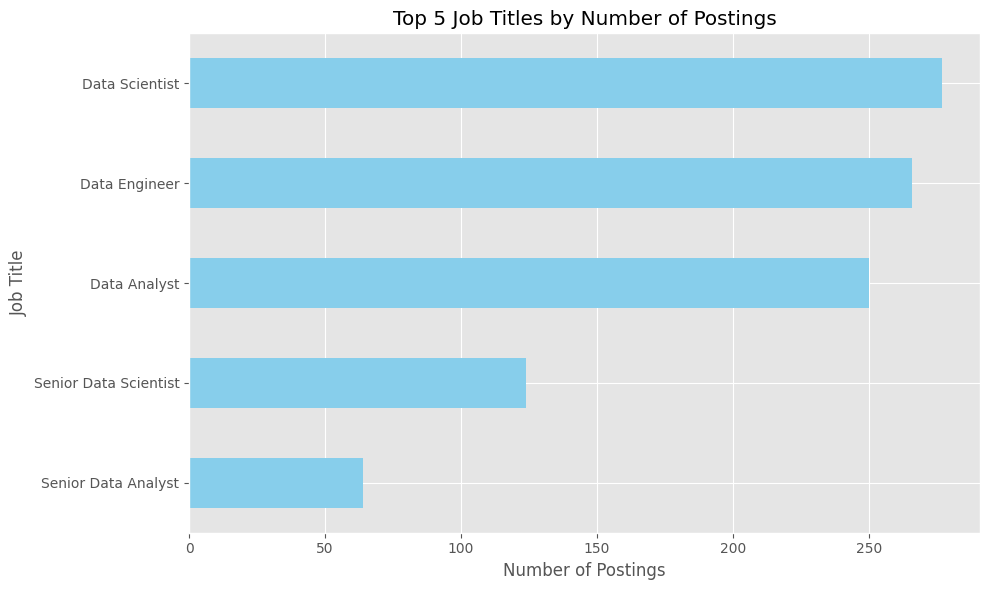

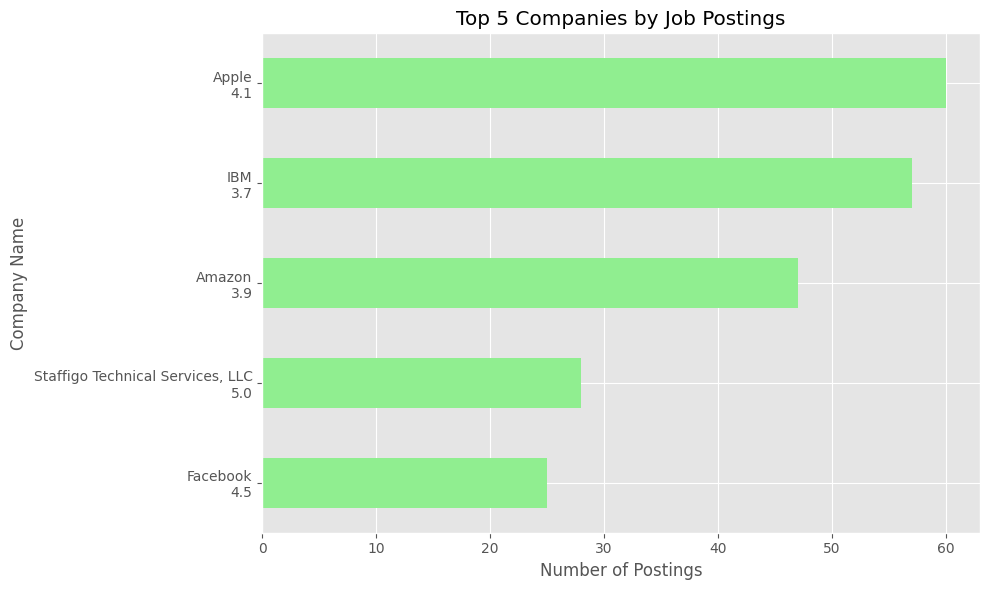

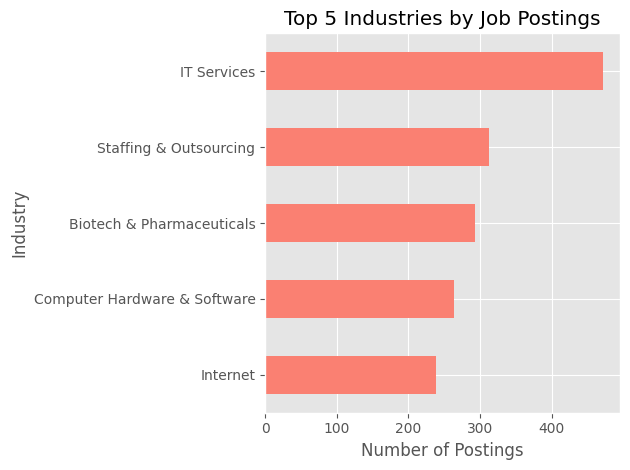

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
# Top job titles. Generate a plot to visualize top 5 job titles based on the number of postings for that same job title.
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
top_job_titles = df['job_title_std'].value_counts().head(5)
top_job_titles.plot(kind='barh', color='skyblue')
plt.title('Top 5 Job Titles by Number of Postings')
plt.xlabel('Number of Postings')
plt.ylabel('Job Title')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Top companies. Generate a plot to visualize top 5 companies based on the number of job postings.
plt.figure(figsize=(10, 6))
top_companies = df['company_name'].value_counts().head(5)
top_companies.plot(kind='barh', color='lightgreen')
plt.title('Top 5 Companies by Job Postings')
plt.xlabel('Number of Postings')
plt.ylabel('Company Name')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
# Top Industry. Generate a plot to visualize top 5 industries based on the number of job postings linked to that industry.
top_industries = df['industry'].value_counts().head(5)
top_industries.plot(kind='barh', color='salmon')
plt.title('Top 5 Industries by Job Postings')
plt.xlabel('Number of Postings')
plt.ylabel('Industry')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Use different styles to generate different layout plots

### 3.2 Salary Analysis
Distribution, central tendency, and top-paying job titles. Print out the mean, median and mode for job salaries. Generate a plot that shows salary distribution (this can be done for all positions collectively).

Mean: $108,033.65
Median: $104,500.00
Mode: $68,500.00


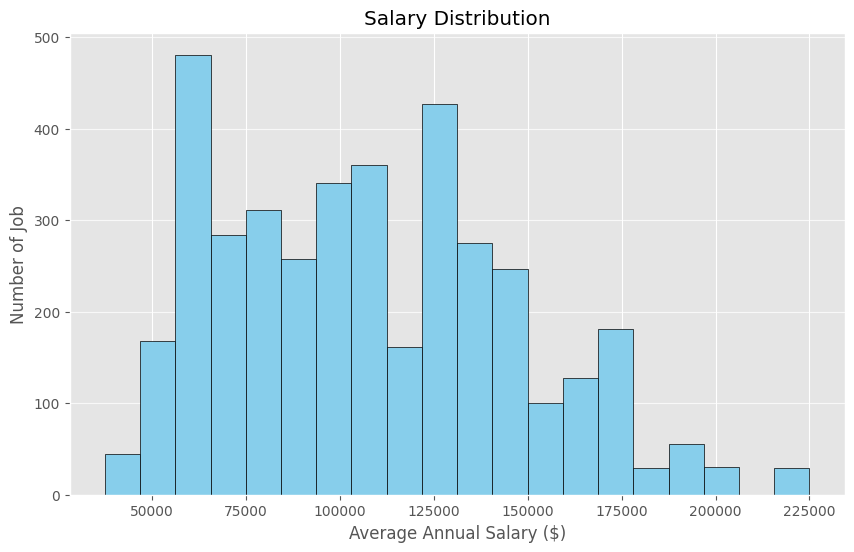

Top Paying Job Titles:
Artificial Intelligence Machine Learning Machine Learning Engineer Advanced Development  -  $225,000
Community Data Manager Single Cell Biology  -  $225,000
Data Science Researcher  -  $225,000
Data Scientist Engineering  -  $225,000
Data Scientist Gateway Analytics (Novi)  -  $225,000
Data Scientist Machine Learning At Google  -  $225,000
Machine Learning Engineer Tiktok Ads Integrity  -  $225,000
Marketing Data Scientist Gtech Professional Services  -  $225,000
Natural Language Processing Data Scientist  -  $225,000
Principal Data Scientist Recommendation Systems  -  $225,000
Senior Data Scientist Analyst  -  $225,000
Senior Data Scientist Machine Learning  -  $225,000
Senior Data Scientist Platform Manipulation  -  $225,000
Senior Hr Data Analyst  -  $225,000
Senior Staff Software Engineer Data Infrastructure  -  $225,000
Staff Data Engineer  -  $225,000
Staff Software Engineer Data Platform  -  $225,000


In [7]:
# mean, median and mode for job salaries
salaries_mean = df['average_salary'].mean()
salaries_median = df['average_salary'].median()
salaries_mode = df['average_salary'].mode()[0]

print(f"Mean: ${salaries_mean:,.2f}")
print(f"Median: ${salaries_median:,.2f}")
print(f"Mode: ${salaries_mode:,.2f}")

# Base on the average_salary, find the distribution.
plt.figure(figsize=(10, 6))
plt.hist(df['average_salary'], bins=20, color='skyblue', edgecolor='black')
plt.title('Salary Distribution')
plt.xlabel('Average Annual Salary ($)')
plt.ylabel('Number of Job')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Find top-paying job titles
avg_salary_by_title = df.groupby('job_title_std')['average_salary'].mean()
max_salary = avg_salary_by_title.max()
print("Top Paying Job Titles:")
top_paying_jobs_titles = avg_salary_by_title[avg_salary_by_title == max_salary]
for title, salary in top_paying_jobs_titles.items():
    print(f"{title}  -  ${salary:,.0f}")

TODO - Findings (if any) goes here

No finding

### 3.3 Remote vs. In-Person Jobs

Some job descriptions note that 'Work Remotely: Yes' which we can assume means this position is fully remote. Lets compare salary ranges for remote vs in-person positions for equivalent job titles.

You don't need to do this for all job titles, but select a few job titles that have a remote and in-person postings and compare their salary range.

Note, it will probably help to first create a new column that denotes if a posting is a remote or in-person job by parsing the job description for hints about remote work.

In [8]:
# create remote_status column to put job's remote status
df['remote_status'] = np.where(
    df['job_description'].str.contains(
        r'(?i)work\s*remotely\s*:\s*yes|remote|work from home|wfh|telecommute',
        na=False
    ),
    'Remote',
    'In-Person'
)

# count how many job has remote or remote/in-person
print(df['remote_status'].value_counts())

# find which position has Remote and In-Person
job_titles_with_both = (
    df.groupby('job_title_std')['remote_status']
    .nunique()
    .reset_index()
    .query('remote_status == 2')['job_title_std']
    .tolist()
)

print("Job titles with both Remote & In-Person postings:")
print(job_titles_with_both)
# find the job status
subset = df[df['job_title_std'].isin(job_titles_with_both)]

# split average salaries in remote and in-person
salary_compare = (
    subset.groupby(['job_title_std', 'remote_status'])['average_salary']
    .mean()
    .reset_index()
    .sort_values(['job_title_std', 'remote_status'])
)

print(salary_compare)

remote_status
In-Person    3484
Remote        425
Name: count, dtype: int64
Job titles with both Remote & In-Person postings:
['Associate Scientist', 'Big Data Engineer', 'Bioinformatics Scientist', 'Business Data Analyst', 'Business Intelligence Analyst', 'Business Intelligence Analyst Senior Marketing', 'Business Intelligence Data Analyst Specialist', 'Data Analyst', 'Data Analyst Intern', 'Data Analyst Marketing', 'Data Analyst(Only W2)', 'Data Analytics Manager', 'Data Engineer', 'Data Engineer Azure', 'Data Engineer Machine Learning', 'Data Modeler', 'Data Science Analyst', 'Data Science Consultant', 'Data Science Intern', 'Data Science Team Lead', 'Data Scientist', 'Data Scientist Advanced Analytics', 'Data Scientist Decisions', 'Data Scientist Engineer', 'Data Scientist Product Analytics', 'Data Scientist Statistician', 'Data Scientist With Security Clearance', 'Environmental Scientist', 'Healthcare Data Scientist', 'Junior Data Analyst', 'Lead Data Analyst', 'Lead Data Engineer

TODO - Findings (if any) goes here

Learned how to find target words in paragrph using ipynb

(?i) can found target words no matter lower case or upper case

In Groupby, we have to use reset_index change the type to dataframe.



### 3.4 Location Distribution
Top locations and salary comparisons across locations.

- Perform analysis and visualize job postings by location. What are your findings?
- Visualize salary (for equivalent positions) by location. What are your findings?

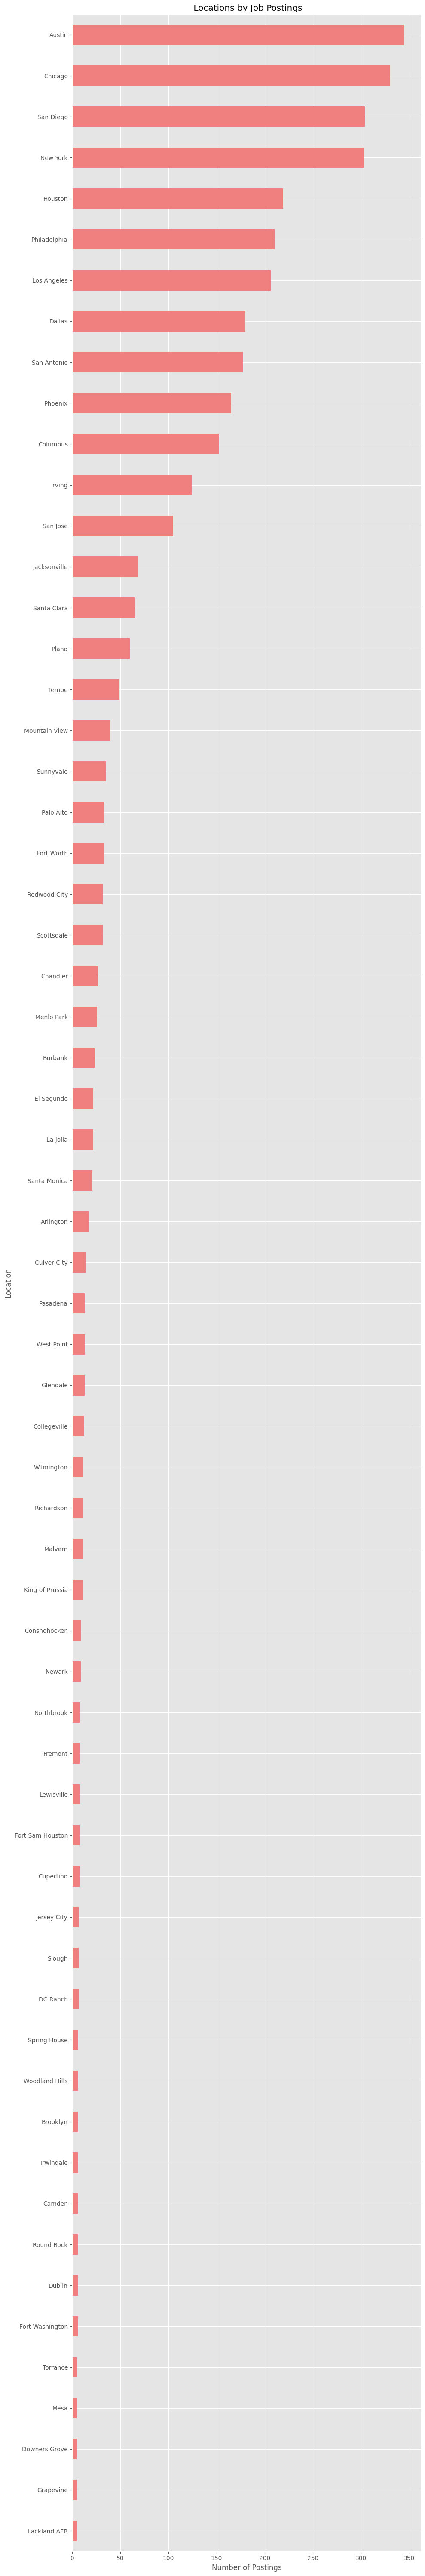

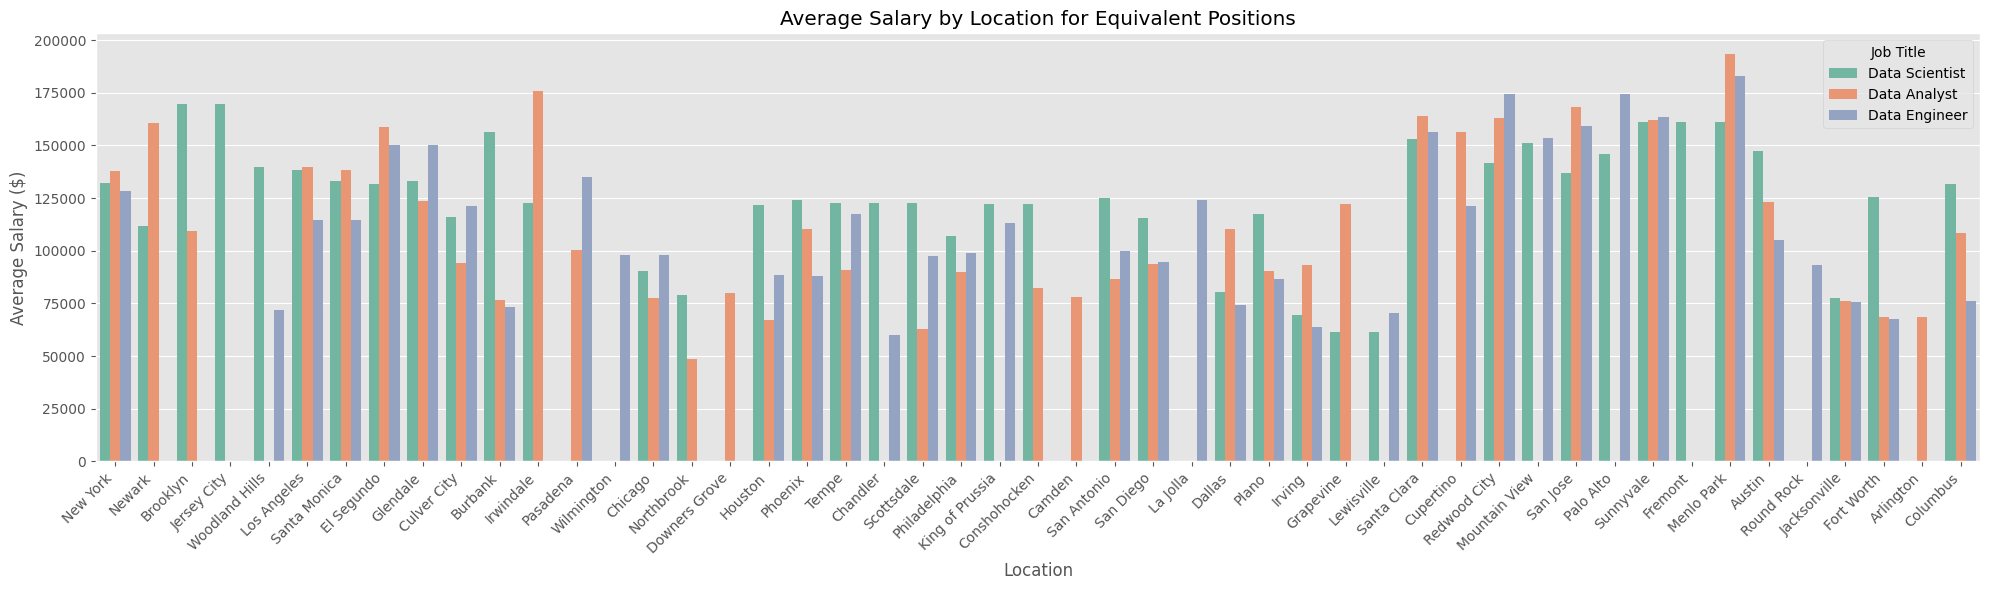

In [9]:
import seaborn as sns
plt.style.use('ggplot')
df['location'] = (
    df['location']
    .astype(str)
    .str.strip()
    .str.replace(r'[^a-zA-Z,\s]', '', regex=True)
    .replace(['-1', 'nan', 'none', ''], pd.NA)
)

# delete no location job
df = df.dropna(subset=['location'])

# Combine same city with different name.
df['location'] = df['location'].str.split(',').str[0].str.strip()

# count how many jobs in one location
location_counts = df['location'].value_counts()

# Only choose location at least has 5 job posting.
valid_locations = location_counts[location_counts >= 5].index
df = df[df['location'].isin(valid_locations)]

#  Top locations by job postings
plt.figure(figsize=(10, 60))
top_locations = df['location'].value_counts()
top_locations.plot(kind='barh', color='lightcoral')
plt.title(' Locations by Job Postings')
plt.xlabel('Number of Postings')
plt.ylabel('Location')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#  Top average salaries by location
# plt.figure(figsize=(10, 6))
# salary_loc = (
#     df.groupby('location')['average_salary']
#     .mean()
#     .sort_values(ascending=False)
# )
# salary_loc.plot(kind='barh', color='lightgreen')
# plt.title(' Locations by Average Salary (All Positions)')
# plt.xlabel('Average Salary ($)')
# plt.ylabel('Location')
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

selected_titles = ['Data Scientist', 'Data Analyst', 'Data Engineer']

subset_multi = df[df['job_title_std'].isin(selected_titles)]

plt.figure(figsize=(20, 6))
sns.barplot(
    data=subset_multi,
    x='location',
    y='average_salary',
    hue='job_title_std',
    palette='Set2',
    errorbar=None
)
plt.title('Average Salary by Location for Equivalent Positions')
plt.xlabel('Location')
plt.ylabel('Average Salary ($)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Job Title')
plt.tight_layout()
plt.show()

### Findings

- Most job postings are concentrated in large tech hubs.
- The highest average salaries are also in these cities, showing a strong correlation between job availability and salary level.
- Some smaller cities show high average salaries, but those may be due to fewer postings or niche high-paying roles.

### 3.5 Skills Analysis

To make this part easier, focus on the 'Data Scientist' job title.

Count frequency of tools/skills across job postings (ex. Hadoop, Spark, Python, R, Tableau, BigData, Pytorch, etc.). What technology / skills should I be teaching in my DS courses to meet the demand from industry?

You can parse the job description and look for specific skills / tools. Consider creating new columns that denote whether a job posting explicitly mentions that skill set. You can then use these columns to evaluate which skills / tools are sought out in industry.

Number of Data Scientist job postings: 924

Top 15 Skills in Data Scientist Job Descriptions:

                  Count  Percentage
R                   924       100.0
C++                 924       100.0
Python              783        84.7
machine learning    681        73.7
SQL                 554        60.0
Excel               361        39.1
Spark               287        31.1
AWS                 242        26.2
big data            234        25.3
Java                215        23.3
Hadoop              195        21.1
Tableau             165        17.9
sas                 152        16.5
deep learning       146        15.8
Tensorflow          144        15.6


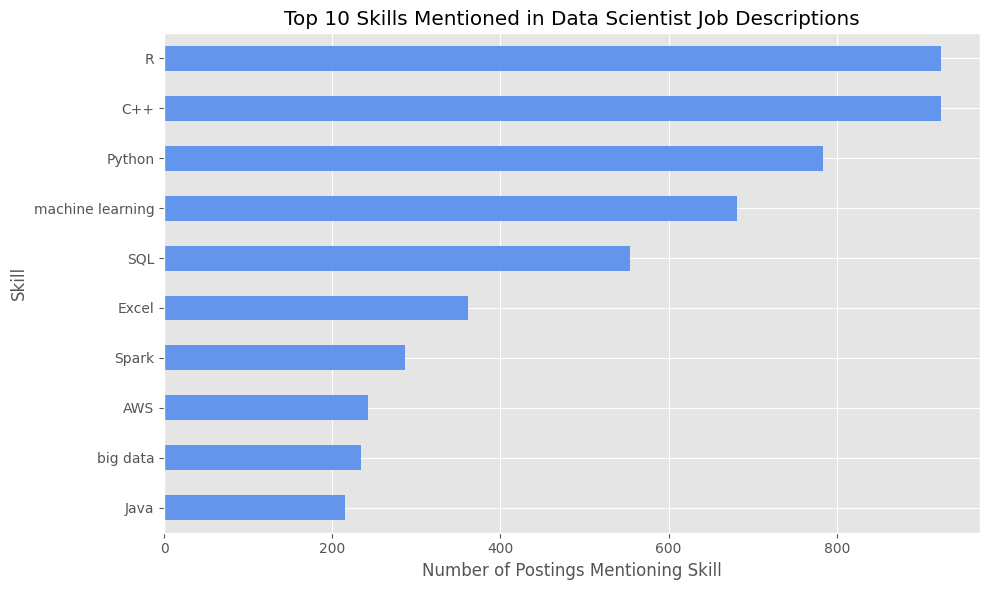

In [10]:
import seaborn as sns

# Focus on Data Scientist roles only
df_ds = df[df['job_title_std'].str.contains('data scientist', case=False, na=False)].copy()
print(f"Number of Data Scientist job postings: {len(df_ds)}")

# Define key skills / tools to search for in job descriptions
skills = [
    'Python', 'R', 'SQL', 'Tableau', 'Power BI', 'Excel',
    'Spark', 'Hadoop', 'AWS', 'Azure', 'gcp', 'big data',
    'Tensorflow', 'keras', 'Pytorch', 'scikit-learn', 'machine learning',
    'deep learning', 'nlp', 'sas', 'matlab', 'Java', 'C++'
]

# Create a new column for each skill
for skill in skills:
    df_ds[skill] = df_ds['job_description'].str.contains(skill, case=False, na=False)

# Count frequency of each skill
skill_counts = df_ds[skills].sum().sort_values(ascending=False)
skill_percent = (skill_counts / len(df_ds) * 100).round(1)

# Combine into one DataFrame
skill_df = pd.DataFrame({
    'Count': skill_counts,
    'Percentage': skill_percent
}).sort_values('Count', ascending=False)

print("\nTop 15 Skills in Data Scientist Job Descriptions:\n")
print(skill_df.head(15))

# Visualize the most frequently mentioned skills
plt.figure(figsize=(10,6))
skill_df.head(10)['Count'].sort_values().plot(kind='barh', color='cornflowerblue')
plt.title('Top 10 Skills Mentioned in Data Scientist Job Descriptions')
plt.xlabel('Number of Postings Mentioning Skill')
plt.ylabel('Skill')
plt.tight_layout()
plt.show()

Python dominates nearly all Data Scientist job postings.
- SQL and cloud platforms (AWS/Azure/GCP) are consistently in demand.
- Machine Learning frameworks such as TensorFlow, PyTorch, and Scikit-learn are frequently mentioned.
- Tableau and Power BI remain important for data visualization and communication.
- Strong coding, data engineering, and modeling skills are clearly valued by industry.

### 3.6 Analysis
Is there any correlation between the type of  industry and the number of jobs and the salary range for those jobs? Generate some plots.

Industry Salary Range (Based on max(high) - min(low)):
                                   industry  job_count  min_low  max_high  \
15             Computer Hardware & Software        259    12000    254000   
41         Health Care Services & Hospitals        178    12000    254000   
27  Enterprise Software & Network Solutions        145    12000    254000   
49                                 Internet        225    12000    254000   
58                    Municipal Governments         10    12000    254000   
..                                      ...        ...      ...       ...   
35                          Food Production          2   119000    147000   
44       Home Furniture & Housewares Stores          1   120000    140000   
42         Health Fundraising Organizations          1   120000    140000   
19                  Consumer Product Rental          1   102000    121000   
84                   Truck Rental & Leasing          1    84000    101000   

    salary_range  
1

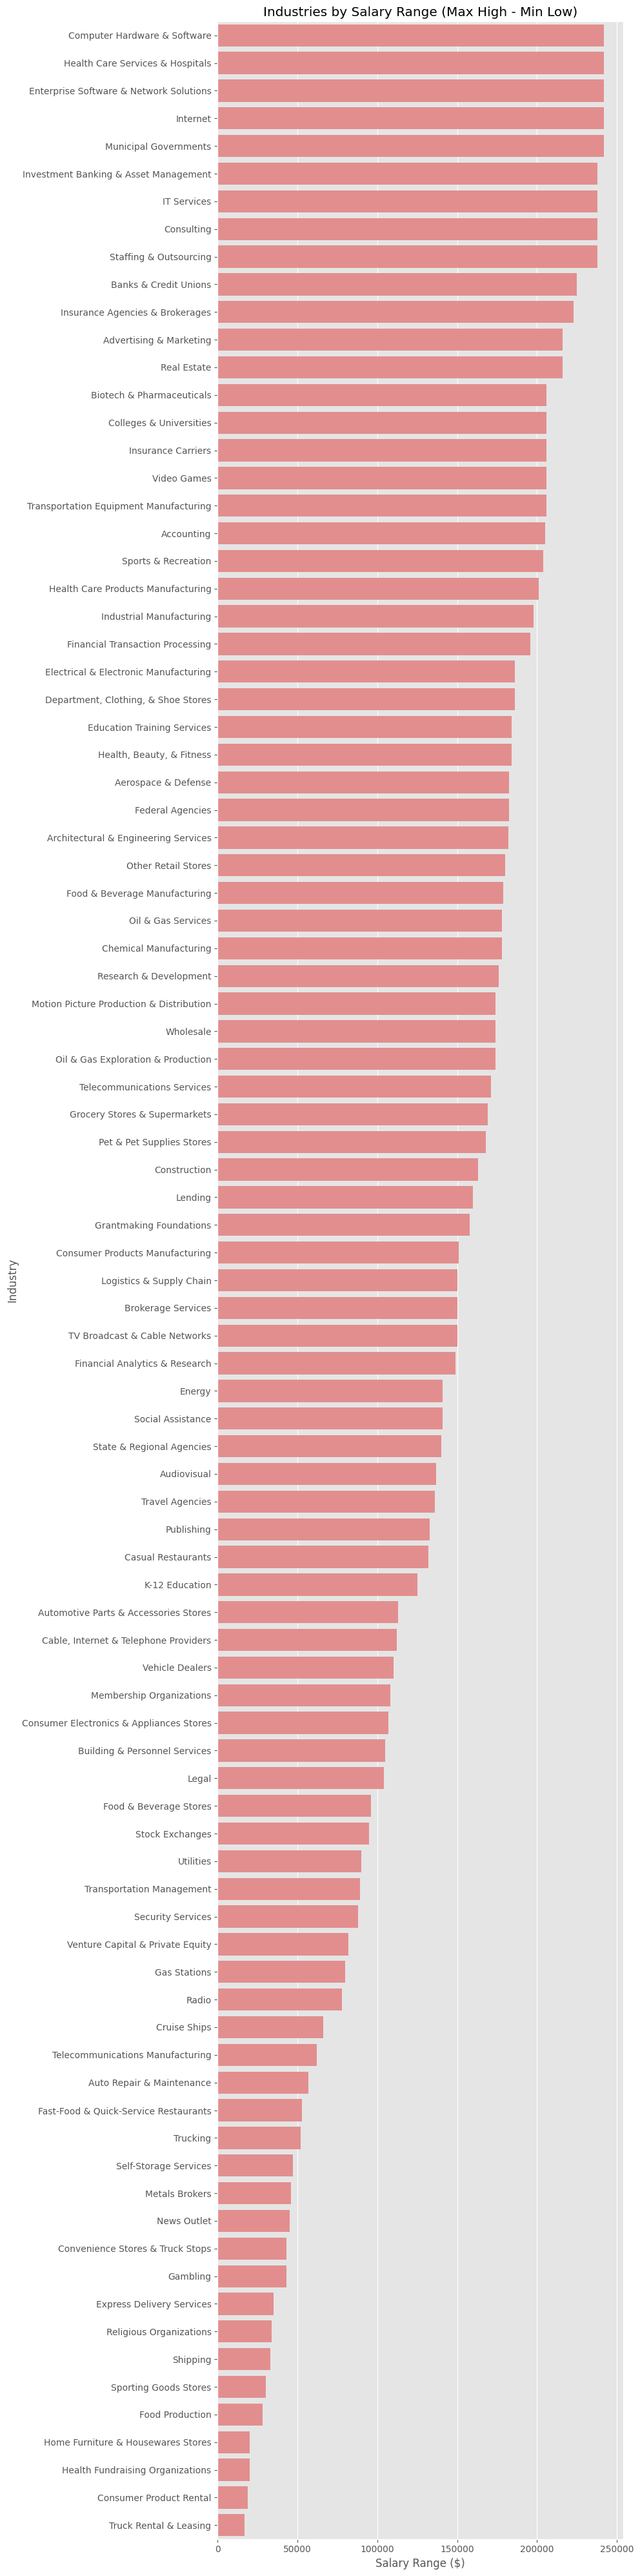

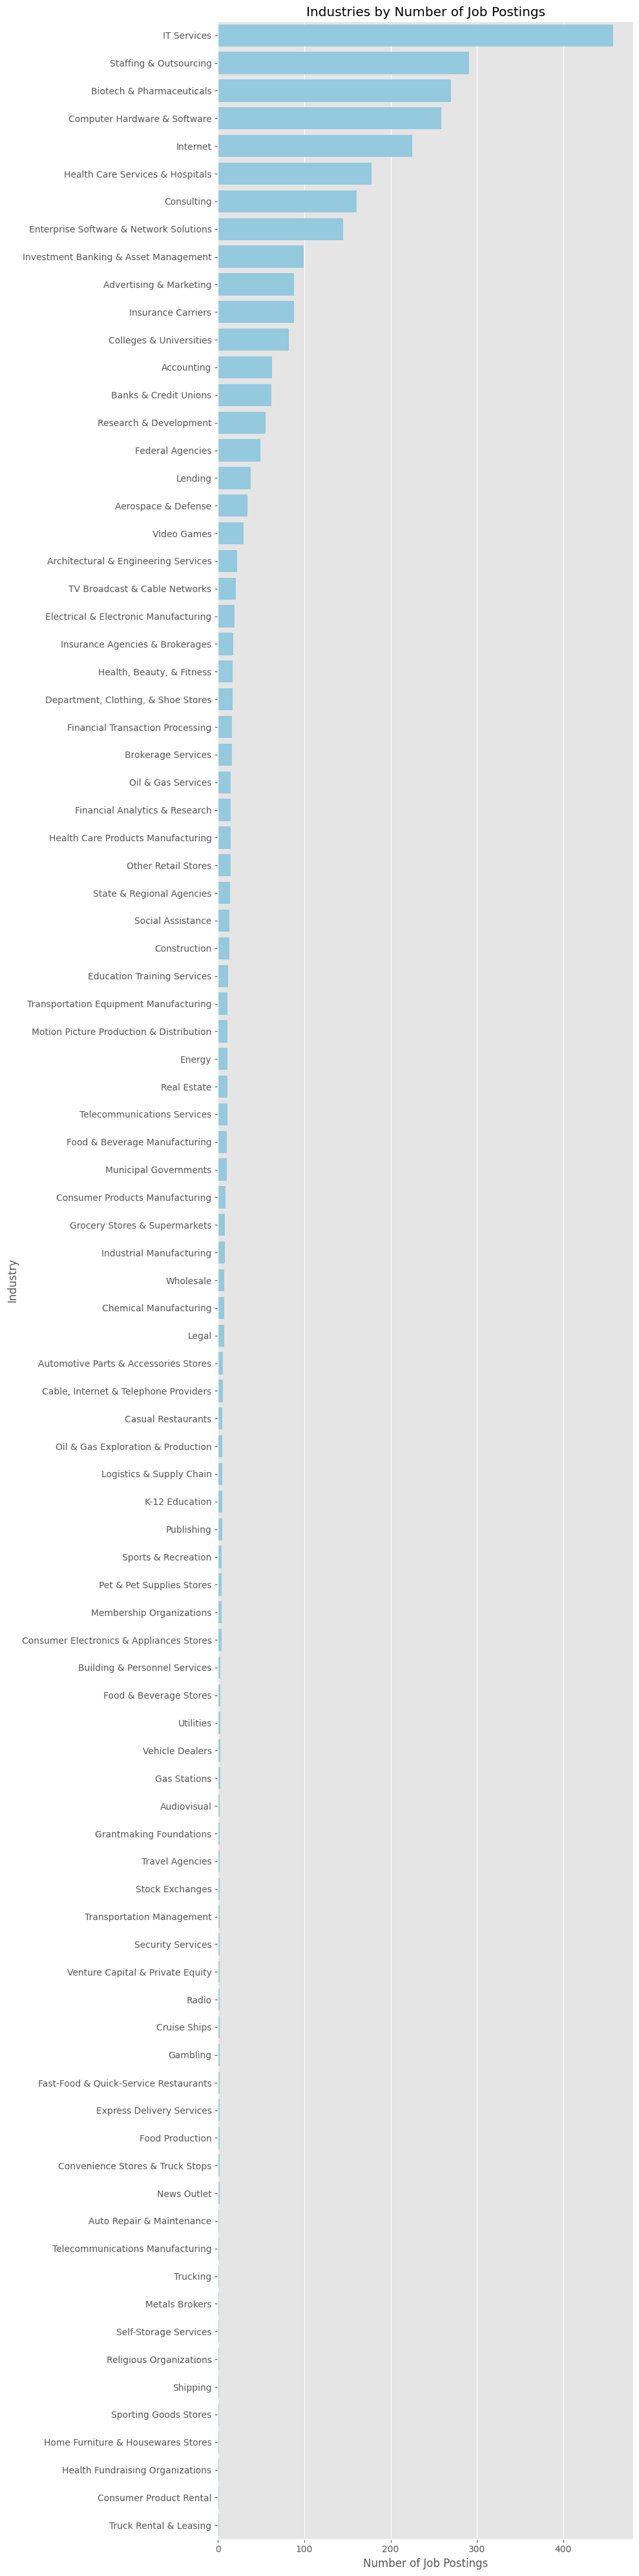

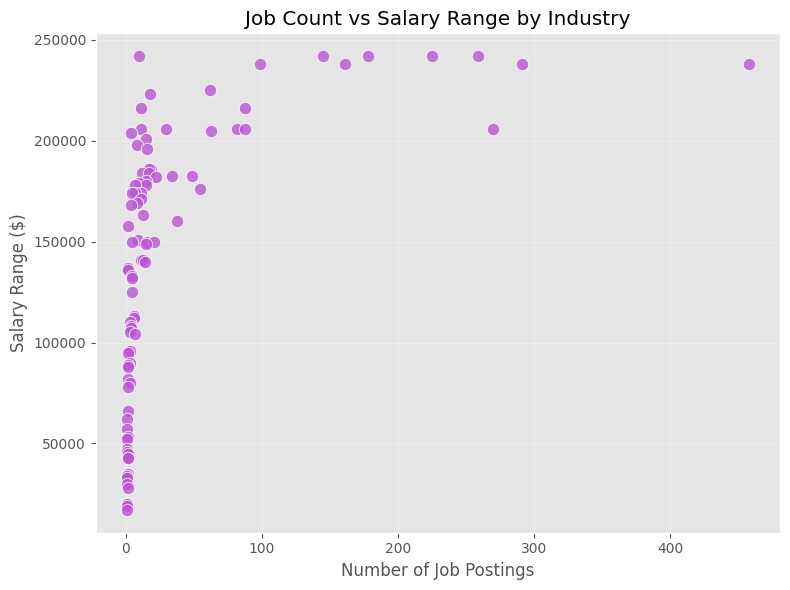

In [11]:
# Clean Invalid Industry Data
df_industry = df[
    (df['industry'] != '-1')
    & (df['industry'].notna())
    & (df['low_salary'].notna())
    & (df['high_salary'].notna())
].copy()

df_industry['industry'] = df_industry['industry'].astype(str).str.strip()

# Calculate Job Count and True Salary Range per Industry
industry_salary = (
    df_industry.groupby('industry')
    .agg(
        job_count=('industry', 'size'),
        min_low=('low_salary', 'min'),
        max_high=('high_salary', 'max')
    )
    .reset_index()
)

# Calculate the true salary range (max high salary minus min low salary)
industry_salary['salary_range'] = industry_salary['max_high'] - industry_salary['min_low']

# Sort by salary range from largest to smallest
industry_salary = industry_salary.sort_values('salary_range', ascending=False)

print("Industry Salary Range (Based on max(high) - min(low)):")
print(industry_salary)

# Visualized Industries Sorted by Salary Range
plt.figure(figsize=(10, 40))
sns.barplot(
    data=industry_salary,
    x='salary_range', y='industry', color='lightcoral'
)
plt.title('Industries by Salary Range (Max High - Min Low)')
plt.xlabel('Salary Range ($)')
plt.ylabel('Industry')
plt.tight_layout()
plt.show()

# Visualized Industries Sorted by Job Postings Count
plt.figure(figsize=(10, 40))
sns.barplot(
    data=industry_salary.sort_values('job_count', ascending=False),
    x='job_count', y='industry', color='skyblue'
)
plt.title('Industries by Number of Job Postings')
plt.xlabel('Number of Job Postings')
plt.ylabel('Industry')
plt.tight_layout()
plt.show()

# Visualized Scatter Plot of Job Count vs Salary Range
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=industry_salary,
    x='job_count', y='salary_range',
    color='mediumorchid', s=80, alpha=0.8
)
plt.title('Job Count vs Salary Range by Industry')
plt.xlabel('Number of Job Postings')
plt.ylabel('Salary Range ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

- Industries with the most job postings are typically IT, Finance, and Consulting sectors.
- The widest salary ranges appear in technology and consulting industries,
  suggesting broader role diversity and seniority levels within these sectors.
- Education and Non-Profit industries have narrow salary ranges, indicating standardized pay scales.

## Step 4: More EDA
Example: Compare salary trends across seniority inferred from job title (entry vs senior). For each job posting, characterize job as either senior, mid or entry. Then determine salary range for each postion. Generate a plot to show how salaries compare.

Job postings by seniority level:
seniority
Other     1804
Senior     994
Mid        790
Entry       99
Name: count, dtype: int64

Average salary and range by seniority:
  seniority  count       avg_low       avg_high  salary_range
0     Entry     99  76747.474747  129767.676768  53020.202020
1       Mid    790  76846.126582  128095.746835  51249.620253
2     Other   1804  83330.354767  135086.762749  51756.407982
3    Senior    994  84455.895372  136927.364185  52471.468813


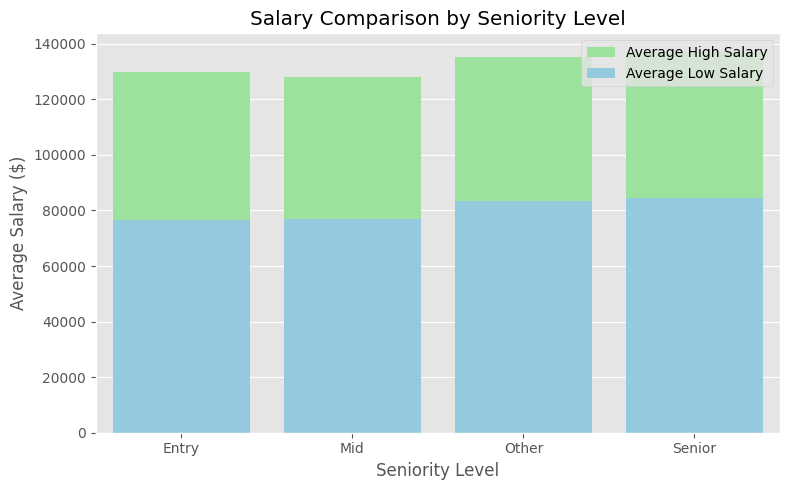

In [12]:
# Create a new column that classifies each job by seniority
def infer_seniority(title):
    # Infer seniority level from the job title text.
    # Returns one of ['Entry', 'Mid', 'Senior', 'Other'].
    t = str(title).lower()
    if any(x in t for x in ['intern', 'entry', 'junior', 'assistant', 'graduate']):
        return 'Entry'
    elif any(x in t for x in ['senior', 'lead', 'principal', 'manager', 'director', 'head']):
        return 'Senior'
    elif any(x in t for x in ['associate', 'staff', 'specialist', 'analyst', 'consultant']):
        return 'Mid'
    else:
        return 'Other'

# Apply the function to the standardized job title column
df['seniority'] = df['job_title_std'].apply(infer_seniority)

# Check how many postings fall in each seniority group
print("Job postings by seniority level:")
print(df['seniority'].value_counts())


# Compute the average salary and range by seniority
seniority_salary = (
    df.groupby('seniority')
    .agg(
        count=('seniority', 'size'),
        avg_low=('low_salary', 'mean'),
        avg_high=('high_salary', 'mean')
    )
    .reset_index()
)
# Compute salary range
seniority_salary['salary_range'] = seniority_salary['avg_high'] - seniority_salary['avg_low']

print("\nAverage salary and range by seniority:")
print(seniority_salary)

# Visualize salary comparison by seniority
plt.figure(figsize=(8, 5))
sns.barplot(
    data=seniority_salary,
    x='seniority', y='avg_high',
    color='lightgreen', label='Average High Salary'
)
sns.barplot(
    data=seniority_salary,
    x='seniority', y='avg_low',
    color='skyblue', label='Average Low Salary'
)

plt.title('Salary Comparison by Seniority Level')
plt.xlabel('Seniority Level')
plt.ylabel('Average Salary ($)')
plt.legend()
plt.tight_layout()
plt.show()

TODO - Findings (if any) goes here

## Step 5: Reflection

**Challenges faced:**
- Try to understand the exact meaning of the question and analyze the ideas for solving the problem.
- Try to find out the function to solve the problem using python.
- I'm having trouble figuring out the core idea of ​​the question, like how to calculate salary ranges for multiple job postings.  
- I have to make sure the data cleaning is going in the right direction before I can do the analysis and get the right results.  
- I need to decide which plot to use to visualize the results.

**Key findings:**
- IT has more opportunities than other industries, but the salary gap is also huge.
